# 4 Mel Frequency Cepstrum Coefficients step-by-step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssi
from scipy import fftpack
from scipy.fftpack.realtransforms import dct
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy
from sklearn.mixture import GaussianMixture
from random import randint
from IPython.display import Audio, Image

from lab1_tools import *
from lab1_proto import *

In [2]:
# Load data (utterances of digits) and example
data = np.load('lab1_data.npz', allow_pickle=True)['data']
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

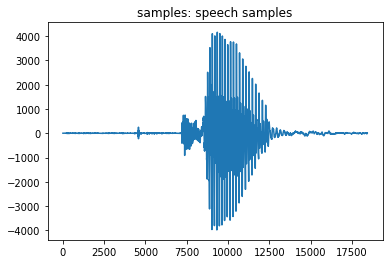

In [3]:
plt.plot(example["samples"])
plt.rcParams["figure.figsize"] = (15,3)
plt.title("samples: speech samples")
plt.show()

# 4.1: Enframe

Figuring out the frame's window length (number of samples per frame) and window shift (number of overlapping samples in consecutive frames) from the signal's sampling rate. The sampling rate is the number of values sampled in one second.

Enframing the speech samples...
The result matches the example.


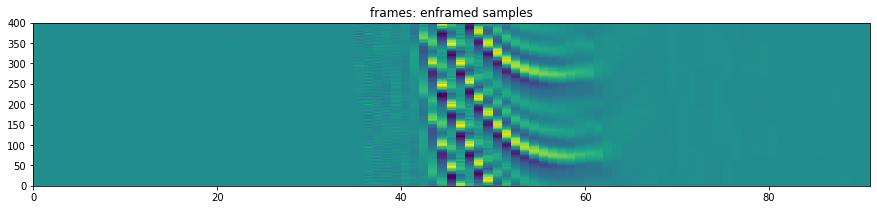

In [4]:
print("Enframing the speech samples...")

num_samples = int(example['samplingrate'] / 1000) # Number of samples per 1ms
winlen = num_samples * 20 # Window length of 20ms ~ number of samples in 20ms
winshift = num_samples * 10 # Window shift in 10ms
frames = enframe(example['samples'], winlen, winshift)

if compare(frames, example['frames']): print("The result matches the example.")
else: print("The result doesn't match the example.")
    
plt.title("frames: enframed samples")
plt.pcolormesh(frames.T)
plt.show()

# 4.2: Pre-emphasis filter

For the definition of the filter coefficients, check the documentation at 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

and slide 67 in lecture 02 (alpha = p = 0.97).

The system response is equivalent to a high-pass filter:

\begin{equation} H(z) = \frac{Y(z)}{X(z)} = 1 - p \, z^{-1} = \frac{z-p}{z}\end{equation}

A high-pass filter passes signals with a frequency higher than a certain cutoff frequency and attenuates signals with frequencies lower than the cutoff frequency. 

Applying pre-emphasis filter...
The result matches the example.


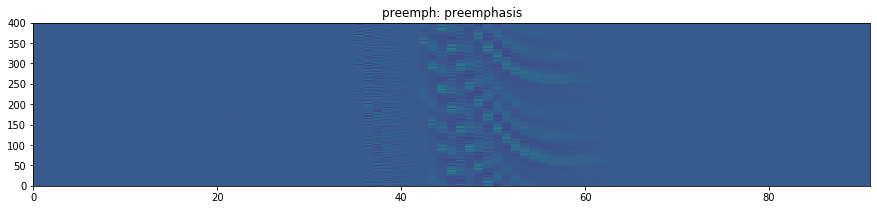

In [5]:
print("Applying pre-emphasis filter...")

pre_emphasis = preemp(frames, 0.97)

if compare(pre_emphasis, example['preemph']): print("The result matches the example.")
else: print("The result doesn't match the example.")

plt.title("preemph: preemphasis")
plt.pcolormesh(pre_emphasis.T)
plt.show()

# 4.3: Hamming window

When we do FFT on finite signal (in the next step), it implicitly applied to infite repeated signal. Computers can't do computations with an infinite number of data points, so all signals are "cut off", unless the start and end value of the singnal match. This causes a "ripple" - a discontinuity in the signal. The hamming window reduces this ripple, giving a more accurate idea of the original signal's frequency spectrum.


Applying hamming window...
The result matches the example.


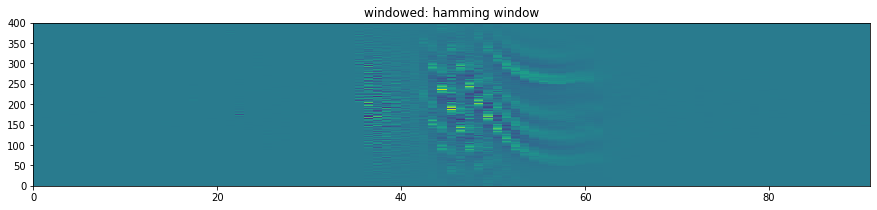

In [6]:
print("Applying hamming window...")
hamming_output = windowing(pre_emphasis)

if compare(hamming_output, example['windowed']): print("The result matches the example.")
else: print("The result doesn't match the example.")
    
plt.title("windowed: hamming window")
plt.pcolormesh(hamming_output.T)
plt.show()

Plotting the hamming window shape...


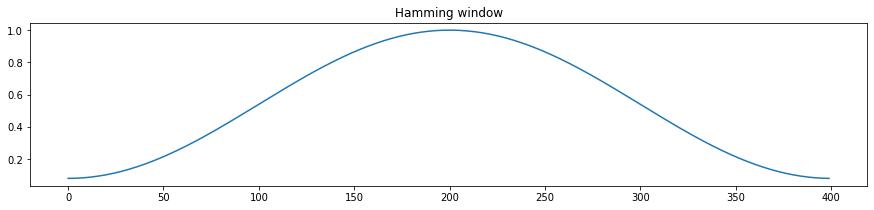

In [7]:
hamming_window = ssi.hamming(pre_emphasis.shape[1], sym=False)

# Plot the hamming window.
print("Plotting the hamming window shape...")
plt.plot(hamming_window)
plt.title("Hamming window")
plt.show()

# 4.4: Fast Fourier Transfrom

According to the Sampling Theorem, f_max is the largest frequency in the signal, and 2 * f_max is the minimum sampling rate (samples per second) for the signal.

Applying Fast Fourier Transfrom...
The result matches the example.


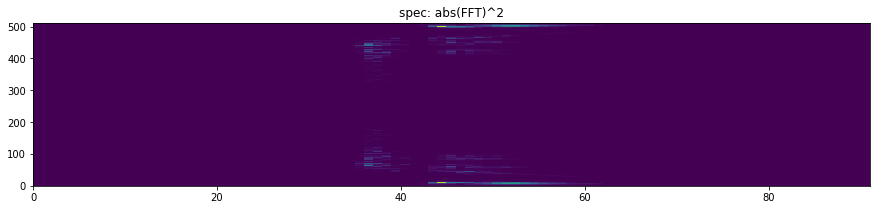

In [8]:
print("Applying Fast Fourier Transfrom...")
FFT = powerSpectrum(hamming_output, 512)

if compare(FFT, example['spec']): print("The result matches the example.")
else: print("The result doesn't match the example.")
    
plt.title("spec: abs(FFT)^2")
plt.pcolormesh(FFT.T)
plt.show()

# 4.5: Mel filterbank log spectrum

Applying Mel filterbank log spectrum...
The result matches the example.


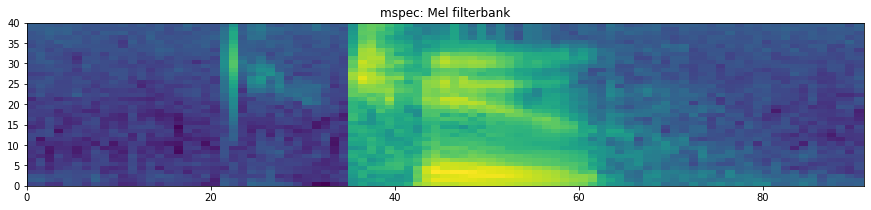

In [9]:
print("Applying Mel filterbank log spectrum...")
MSPEC = logMelSpectrum(FFT, 20000)

if compare(MSPEC, example['mspec']): print("The result matches the example.")
else: print("The result doesn't match the example.")
    
plt.title("mspec: Mel filterbank")
plt.pcolormesh(MSPEC.T)
plt.show()

Plotting the filters in linear frequency scale...


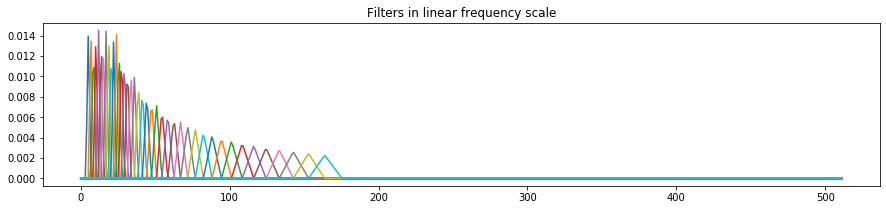

In [10]:
filters = trfbank(20000, FFT.shape[1])

print("Plotting the filters in linear frequency scale...")
plt.title("Filters in linear frequency scale")
for f in filters:
    plt.plot(f)
plt.show()

Mel-frequency scaling is a perceptual scale that helps to simulate the way human ear works. It corresponds to better resolution at low frequencies and less at high. Using the triangular filter-bank helps to capture the energy at each critical band and gives a rough approximation of the spectrum shape, as well as smooths the harmonic structure.

# 4.6: Cosine transform and liftering

Applying cosine transform...
The result matches the example.


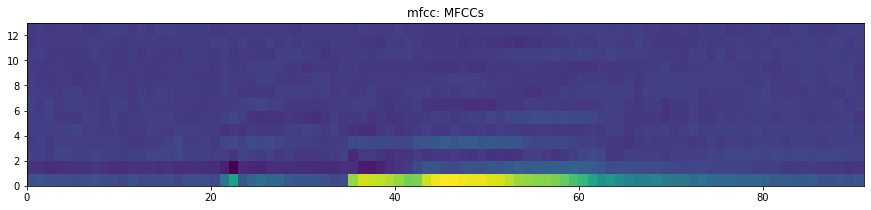

In [11]:
print("Applying cosine transform...")
MFCC = cepstrum(MSPEC, 13)

if compare(MFCC, example['mfcc']): print("The result matches the example.")
else: print("The result doesn't match the example.")

plt.title("mfcc: MFCCs")
plt.pcolormesh(MFCC.T)
plt.show()

Applying liftering...
The result matches the example.


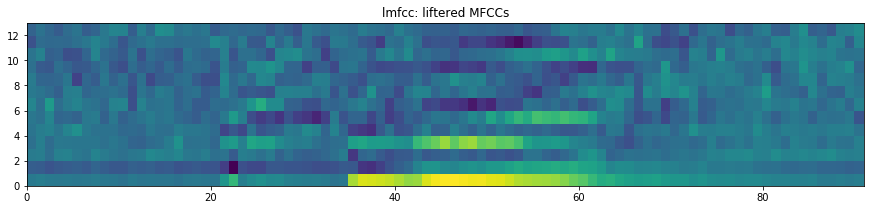

In [12]:
print("Applying liftering...")
LMFCC = lifter(MFCC)

if compare(LMFCC, example['lmfcc']): print("The result matches the example.")
else: print("The result doesn't match the example.")
    
plt.title("lmfcc: liftered MFCCs")
plt.pcolormesh(LMFCC.T)
plt.show()

In [13]:
# Apply to data

# First step
mfcc_features = mfcc(data[0]['samples']) # liftered
mspec_features = mspec(data[0]['samples'])

# Compute the mspec and mfcc for all utterances and stack them
for i in range(1, len(data)):
    mfcc_features = np.vstack((mfcc_features, mfcc(data[i]['samples']))) # liftered
    mspec_features = np.vstack((mspec_features, mspec(data[i]['samples'])))

# Feature Comparison

In [14]:
SAMPLING_RATE = 20000

In [15]:
utterance_oh_male = data[0]['samples']
Audio(utterance_oh_male, rate=SAMPLING_RATE)

In [16]:
utterance_oh_female = data[23]['samples']
Audio(utterance_oh_female, rate=SAMPLING_RATE)

In [17]:
utterance_zero_male = data[2]['samples']
Audio(utterance_zero_male, rate=SAMPLING_RATE)

In [18]:
utterance_zero_female = data[25]['samples']
Audio(utterance_zero_female, rate=SAMPLING_RATE)

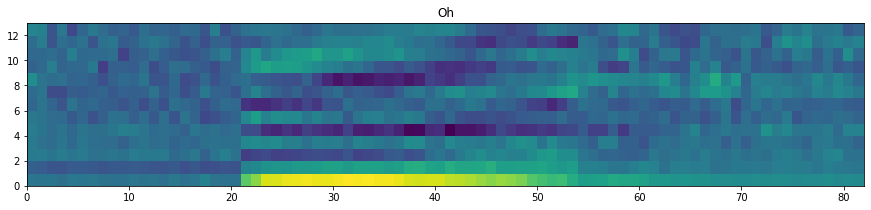

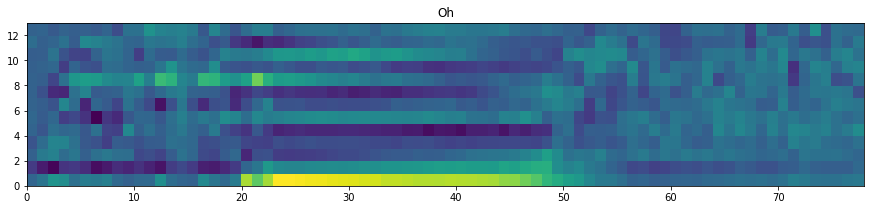

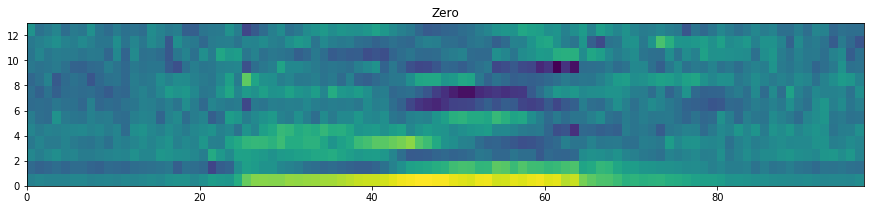

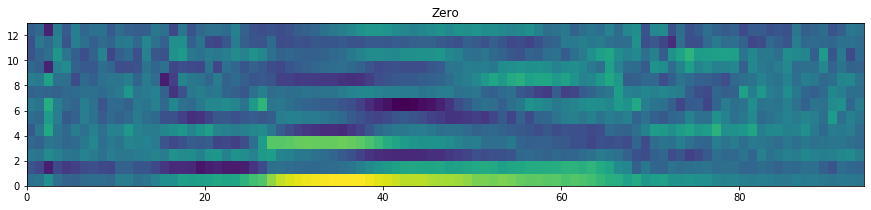

In [19]:
plt.title("Oh")
plt.pcolormesh(mfcc(utterance_oh_male).T)
plt.show()

plt.title("Oh")
plt.pcolormesh(mfcc(utterance_oh_female).T)
plt.show()

plt.title("Zero")
plt.pcolormesh(mfcc(utterance_zero_male).T)
plt.show()

plt.title("Zero")
plt.pcolormesh(mfcc(utterance_zero_female).T)
plt.show()

# 5: Feature Correlation

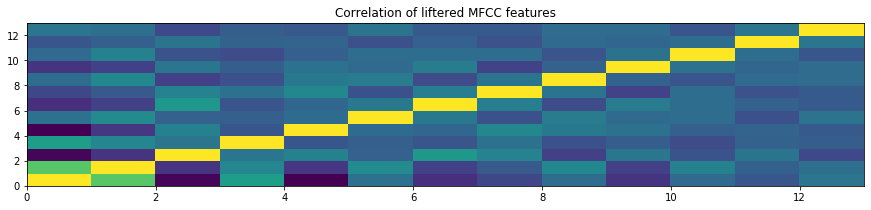

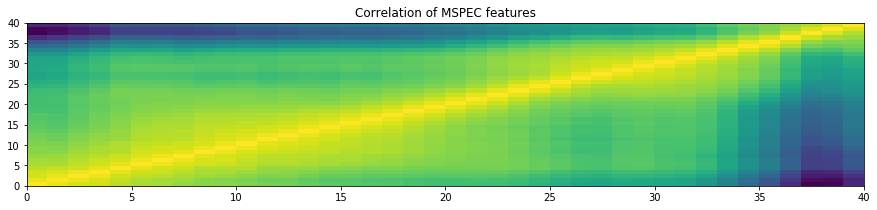

In [20]:
mfcc_correlation = np.corrcoef(mfcc_features.T)
plt.title("Correlation of liftered MFCC features")
plt.pcolormesh(mfcc_correlation)
plt.show()

mspec_correlation = np.corrcoef(mspec_features.T)
plt.title("Correlation of MSPEC features")
plt.pcolormesh(mspec_correlation)
plt.show()

Since the correlation matrix is almost diagonal, the features are correlated. This justifies the assumption for diagonal Gaussian covariances. The MSPEC features of the Mel filter-band are much more correlated that the ones after applying the Discrete Cosine Transform.

# 6: Speech Segments with Clustering

Score with 4 components is: 7.017017822968152e-30
Score with 8 components is: 9.874139416574284e-30
Score with 16 components is: 8.132511795077299e-29
Score with 32 components is: 1.0567209121266677e-28


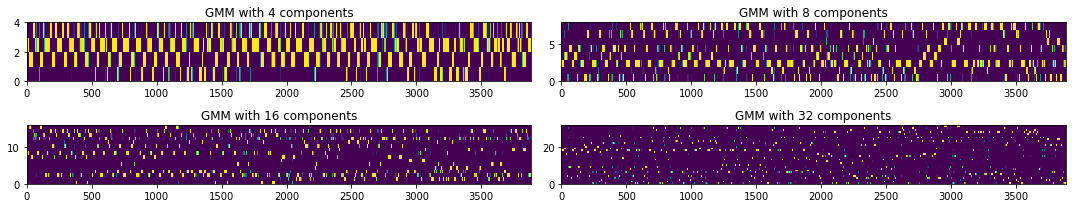

In [21]:
# Fit a Gaussian Mixture Model to the data

num_components = [4, 8, 16, 32]
subplots = 221
for component in num_components:
    model = GaussianMixture(n_components=component, covariance_type='diag')
    model.fit(mfcc_features)
    score = np.exp(model.score_samples(mfcc_features))    
    print("Score with {} components is: {}".format(component, sum(score)))
    posteriors = model.predict_proba(mfcc_features)

    plt.subplot(subplots)
    plt.pcolormesh(posteriors.T)
    subplots += 1
    plt.title('GMM with {} components'.format(component))

plt.tight_layout()
plt.show()

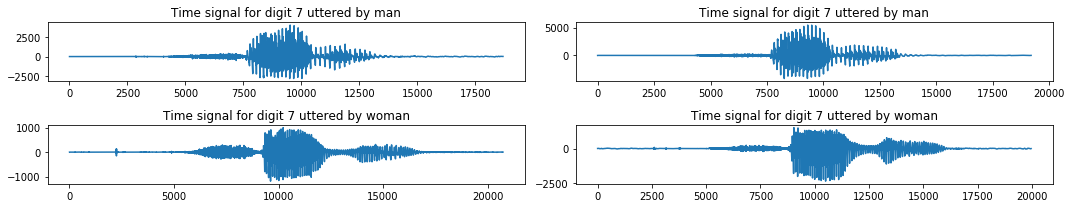

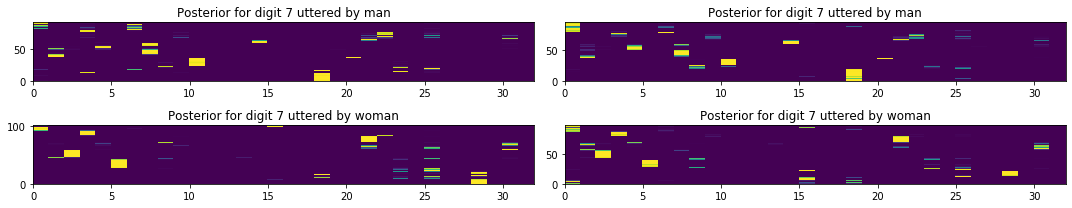

In [22]:
data_seven = np.array(list(filter(lambda x: x['digit'] == '7', data)))

subplots = 221
for idx in range(len(data_seven)):
    # plt.subplots(nrows=2, ncols=2)
    plt.subplot(subplots)
    subplots += 1
    plt.title('Time signal for digit {} uttered by {}'.format(data_seven[idx]['digit'], data_seven[idx]['gender']))
    plt.plot(data_seven[idx]['samples'])

plt.tight_layout()
plt.show()

subplots = 221
for idx in range(len(data_seven)):

    mfcc_features = mfcc(data_seven[idx]['samples'])
    plt.subplot(subplots)
    subplots += 1
    posteriors = model.predict_proba(mfcc_features)
    plt.pcolormesh(posteriors)
    plt.title("Posterior for digit {} uttered by {}".format(data_seven[idx]['digit'], data_seven[idx]['gender']))

plt.tight_layout()
plt.show()

# 7: Comparing Utterances

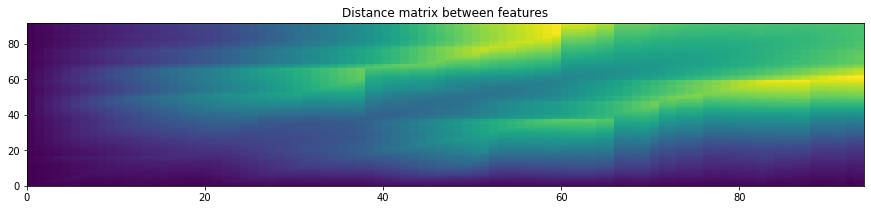

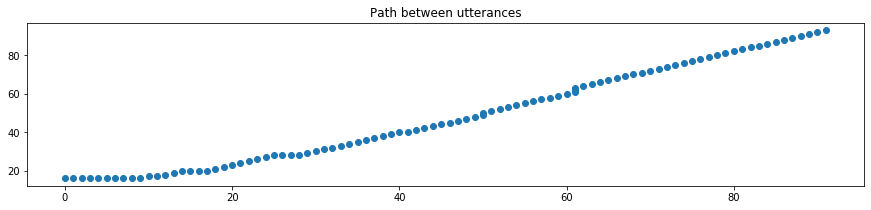

In [23]:
# Compare two utterances

utterance_1 = mfcc(data[16]['samples']) 
utterance_2 = mfcc(data[17]['samples'])
dist_DTW, dist_loc, AccD_mat, path = dtw(utterance_1, utterance_2, getEuclidean)

plt.pcolormesh(AccD_mat)
plt.title('Distance matrix between features')
plt.show()
    
plt.title("Path between utterances")
plt.scatter(np.array(path[:])[:, 0], np.array(path[:])[:, 1])
plt.show()

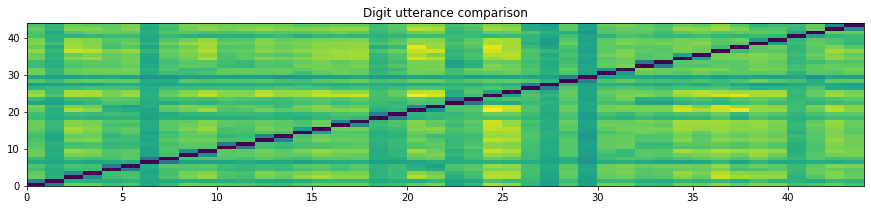

C:\Users\bjeli\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


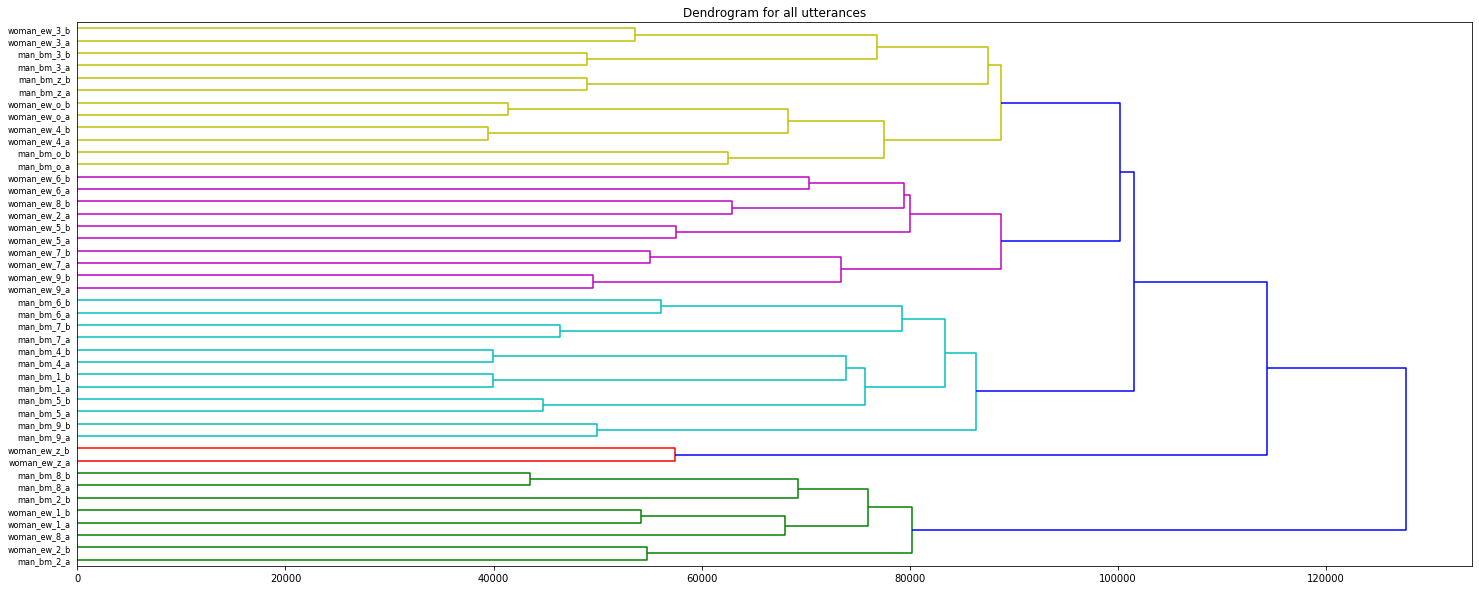

In [24]:
# Compare all features

matrix_dtw = np.zeros((len(data),len(data)))

for i in range(matrix_dtw.shape[0]):
    for j in range(matrix_dtw.shape[1]):
        # dist_DTW, _, _, _ = dtw(mfcc(data[i]['samples']), mfcc(data[j]['samples']), getEuclidean, Comp_Dist = False)
        dist_DTW = dtw(mfcc(data[i]['samples']), mfcc(data[j]['samples']), getEuclidean, Comp_Dist = True)
        matrix_dtw[i][j] = dist_DTW
    
plt.title("Digit utterance comparison")
plt.pcolormesh(matrix_dtw)
plt.show()

clusters = hierarchy.linkage(matrix_dtw, method='complete')
  
# plt.figure(figsize=(25, 10))
plt.figure(figsize=(25, 10))
hierarchy.dendrogram(clusters, labels=tidigit2labels(data), orientation='right')
plt.title('Dendrogram for all utterances')
plt.show()